In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using Plots
using Colors
using IterTools
Threads.nthreads()


(process:12612): GLib-GIO-WARNING **: 17:31:11.261: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_19.0.3.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [2]:
function hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V, m, M, ħ)
    # BLOC EXTRA-DIAGONAL
    J = -ħ^2*  1/(2*M*Δy²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*Δx²)+1/(M*Δy²))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*Δx²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = -ħ^2*  SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end

    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(Δd², N, V, m, ħ)
    Λ = -ħ^2*1/(Δd²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = sparse(Diagonal(V)); # V_fun.(LinRange(xmin,xmax,N)) pour créer l'argument
    H = Λ + V; 
    H, Λ, V
end

hamiltonian_1D (generic function with 1 method)

In [3]:
# DÉRIVÉES PREMIÈRES
# ∂ première à l'ordre 2
diff1_ctr_o2  = [-1/2 0. 1/2];

# ∂ première à l'ordre 4
diff1_fwd_o4  = [−25/12 4. −3. 4/3 −1/4];
diff1_bwd_o4  = [1/4 -4/3 3. -4 25/12];
diff1_ctr_o4 = [+1/12, −2/3,  0.,  2/3, −1/12];

# ∂ première à l'ordre 6
diff1_ctr_o6  = [−1/60 3/20 −3/4 0. 3/4 −3/20 1/60];
diff1_fwd_o6  = [−49/20 6. −15/2 20/3 −15/4 6/5 −1/6];
diff1_bwd_o6 = [1/6 -6/5 15/4 -20/3 15/2 -6. 49/20];


# ∂ première à l'ordre 8
diff1_ctr_o8 =  [1/280 −4/105 1/5 −4/5 0. 4/5 −1/5 4/105 −1/280];
diff1_fwd_o8  = [-760/280 8. -14. 56/3 -35/2 56/5 -14/3 8/7 -1/8];
diff1_bwd_o8  = [1/8 -8/7 14/3 -56/5 35/2 -56/3 14. -8. 760/280];


# DÉRIVÉES SECONDES
# ∂ seconde à l'ordre 6
diff2_ctr_o6 = [1/90 -3/20 3/2 -49/18 3/2 -3/20 1/90];
diff2_fwd_o6 = [469/90 -223/10 879/20 -949/18 41. -201/10 1019/180 -7/10];
diff2_bwd_o6 = [-7/10 1019/180 -201/10 41. -949/18 879/20 -223/10 469/90];


# ∂ seconde à l'ordre 8
diff2_ctr_o8 = [−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560];

On part d'un hamiltonien représentant par exemple, l'énergie de la molécule H_2^+.
\begin{equation}
 -\frac{1}{2m} \frac{\partial^2}{\partial x^2} - \frac{1}{2M} \frac{\partial^2}{\partial y^2} + V(x,y)
\end{equation}
Qu'on décompose en trois termes
\begin{equation}
H = \hat{H}_x + \hat{H}_y + \hat{W}
\end{equation}

\begin{equation}
\hat{H}^0_y =  - \frac{1}{2m} \frac{\partial^2}{\partial y^2} + \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0)(y-y_0)^2 
\end{equation}

\begin{equation}
        \hat{H}^0_x = - \frac{1}{2M} \frac{\partial^2}{\partial x^2} + V(x,y_0)   
\end{equation}


\begin{equation}
\hat{W} = \frac{\partial V}{\partial y}(x,y_0)(y-y_0)  + \frac{1}{2} \left(\frac{\partial^2V}{\partial y^2}(x,y_0) -\frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0) \right)   (y-y_0)^2 + \text{h.o.t.}
\end{equation}


In [4]:
# Dans la fonction suivante toutes les variables avec chapeau désignent des opérateurs 2D (matrices N² × N²)
# Les Λ (sans chapeau) sont aussi des opérateurs (ce sont les laplaciens)
function decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_fun, m, M, ħ, kdim)
    Δx = (xmax-xmin)/(N-1);
    Δy = (ymax-ymin)/(N-1);
    Δx² = Δx*Δx;
    Δy² = Δy*Δy;
    N² = N*N;

    # CONSTRUCTION DE LA MESHGRID
    xs = Vector(xmin:Δx:xmax); # direction coordonnée électron
    ys = Vector(ymin:Δy:ymax); # direction coordonnée distance noyau-noyau
    X = ones(N)' .* xs;
    Y = ys' .* ones(N);
    V = zeros(N,N);

    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN
    @. V = V_fun(X, Y);
    Ĥ, Λ, V̂ = hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V, m, M, ħ);
    lowest_energies_y = zeros(N);

    K̂ = SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1)); # structure du laplacien

    # LAPLACIENS SUR AXES
    Λx = -ħ^2*1/(Δx²*2*m)*K̂;  # laplacien sur l'axe x
    Λy = -ħ^2*1/(Δy²*2*M)*K̂;  # laplacien sur l'axe y


    # RECHERCHE DU y₀  minimisant l'énergie de l'état fondamental
    lE₀ = zeros(N);
    Base.Threads.@threads for j in 1:N
        Vx = sparse(Diagonal(V[:,j])) # potentiel en x à j=jΔy fixé (i.e. à distance noyau-noyau fixé)
        vals, ~, infos = KrylovKit.eigsolve(Λx+Vx, N, 1, :SR, krylovdim=kdim); 
        lE₀[j]     = infos.converged>=1 ? vals[1]    : NaN; 
        # on récupère l'énergie  propre du niveau fondamental sur la tranche à y fixé
    end  

    # CALCUL DU y₀ ET DES RAIDEURS
    E₀_at_y₀, ind_y₀ = findmin(lE₀);
    y₀               = ind_y₀*Δy + ymin;
    ∂²yyE₀_at_y₀     = 1/(Δy)^2 * dot(diff2_ctr_o8, view(lE₀, ind_y₀-4:ind_y₀+4));  # on calcule la dérivée seconde  à l'ordre 8 par rapport à y de E₀ en y₀
    # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturbé

    # FONCTIONS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS  
    V₀x = @views V[:,ind_y₀];
    V₀y = @views .5*∂²yyE₀_at_y₀*(ys.-y₀).^2;
    # les potentiels opérateurs correpondants sur chaque axe s'obtiennent
    # en appliquant sparse ∘ Diagonal

    # OPÉRATEURS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS 
    V̂⁰x = sparse(Diagonal(V₀x));
    V̂⁰y = sparse(Diagonal(V₀y));

    # HAMILTONIENS NON PERTURBÉS SUR AXES SÉPARÉS
    Ĥ⁰x = Λx + V̂⁰x;
    Ĥ⁰y = Λy + V̂⁰y;

    # FONCTION POTENTIEL NON PERTURBÉ SUR GRILLE
    V₀ = @views V[:,ind_y₀]*ones(N)' + .5*∂²yyE₀_at_y₀*(Y.-y₀).^2;
    # OPÉRATEUR POTENTIEL NON PERTURBÉ SUR GRILLE
    V̂⁰ = Diagonal(reshape(V₀,N²));
    Ĥ⁰ = Λ + V̂⁰;
    

    # FONCTION PERTURBATION Vp (développement de Taylor)
        # ordre 1 en espace
    ∂yV_atxy₀   = 1/Δy*  V[:,ind_y₀-4:ind_y₀+4] * diff1_ctr_o8'; # vecteur contenant ∂V/∂y(x,y₀)   pour tous les x
    V₁          = ∂yV_atxy₀*ones(N)' .* (Y.-y₀);
        # ordre 2 en espace
    ∂²yyV_atxy₀ = 1/Δy²* V[:,ind_y₀-4:ind_y₀+4] * diff2_ctr_o8'; # vecteur contenant ∂²V/∂y²(x,y₀) pour tous les x
    V₂          = (∂²yyV_atxy₀*ones(N)' .- .5*∂²yyE₀_at_y₀).*(Y.-y₀).^2;
    # perturbation totale ordre 1 + ordre 2
    Vp  = V₁ + V₂;

    # OPÉRATEUR PERTURBATION Ŵ
    Ŵ = Diagonal(reshape(Vp, N²));
    
    return Λ, Ĥ, V̂, V, Ĥ⁰, V̂⁰, V₀, Ĥ⁰x, Ĥ⁰y, V̂⁰x, V̂⁰y, V₀x, V₀y, Ŵ, Vp, V₁, V₂, lE₀, ind_y₀, y₀, Δx, Δy, xs, ys, ∂²yyE₀_at_y₀, ∂²yyV_atxy₀, ∂yV_atxy₀

end

decompose_hamiltonian (generic function with 1 method)

### 1) Création d'un problème avec un potentiel

In [8]:
# A = rand(2,2);
# A = Matrix{Float64}(I, 2,2);

A = [0.7 0.4; 0.4 0.8];
psd = 2*A'*A;
m = 1; m = 6;
xmin=-5.; xmax=5.; ymin=-2.; ymax=2.; N=80; ω=1.; ħ=1.; kdim=30; # augmenter la dimension Krylov quand N est grand: pour N=200, prendre kdim=50

function V_func(x,y)
     return .5*m*ω^2*dot([x, y], psd*[x, y]) #  -3/(.5+sqrt(.05(x+2.5)^2+.05(y-2.6)^2)); # somme d'un oscillateur et d'un potentiel coulombien 
end

V_func (generic function with 1 method)

### 2) Décomposition (approchée) d'un hamiltonien perturbé $H_0$ et d'une correction $\hat{W}$.
Remarque: lorsqu'on plot une heatmap d'une matrice avec l'axe des $x$ indicé $i$ et l'axe $y$ indicé $j$, on doit transposer car https://discourse.julialang.org/t/hi-evrybody-im-trying-to-overlay-a-scatter-plot-with-a-heatmap-using-plots-jl-bu/56067


$y₀$ minimise l'énergie de l'état fondamental du hamiltonien pris sur l'axe $y=y₀$ (la tranche)

  8.394404 seconds (21.21 M allocations: 1.054 GiB, 7.16% gc time, 98.92% compilation time)
ky=2.9538
y₀=0.0759
E₀(y₀)=0.567
isposdef(Ĥ) = true


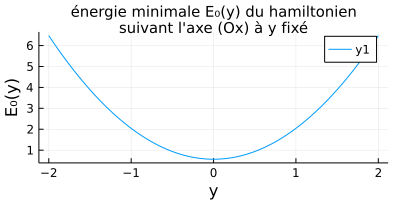

In [9]:
# 1 min pour 400 par 400, 20 sec pour 300 par 300
@time   Λ,                            # laplacien 2D commun
        Ĥ,   V̂,   V,                  # opérateurs et potentiel 2D originaux
        Ĥ⁰,  V̂⁰,  V₀,                 # hamiltonien et potentiel 2D non perturbés
        Ĥ⁰x, Ĥ⁰y, V̂⁰x, V̂⁰y, V₀x, V₀y, # opérateurs et potentiels 1D non perturbés
        Ŵ,   Vp,  V₁,  V₂,            # hamiltonien et potentiel de la perturbation et sa décomposition
        lE₀, ind_y₀, y₀,              # liste des énergies sur Ox en fonction de y et minimum y₀
        Δx, Δy, xs, ys,               # paramètres du problème
        ∂²yyE₀_at_y₀, ∂²yyV_atxy₀, ∂yV_atxy₀ = decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_func, m, M, ħ, kdim);
        
        
println("ky=$(round(∂²yyE₀_at_y₀,digits=4))\ny₀=$(round(y₀,digits=4))\nE₀(y₀)=$(round(lE₀[ind_y₀],digits=3))")
@show isposdef(Ĥ)
plot(ys,lE₀, title="énergie minimale E₀(y) du hamiltonien\nsuivant l'axe (Ox) à y fixé",xlabel="y", ylabel="E₀(y)", size=(400,200), titlefontsize=10)

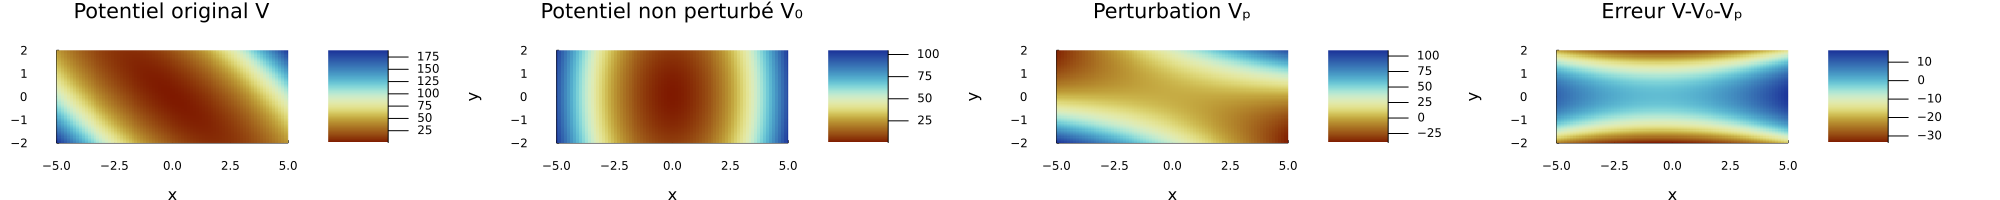

In [10]:
plot_V  = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Potentiel original V", grid=true, aspect_ratio=:equal ) 
plot_V₀ = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V₀', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Potentiel non perturbé V₀", aspect_ratio=:equal )
plot_Vp = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), Vp', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Perturbation Vₚ", aspect_ratio=:equal )
plot_dif = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V-V₀-Vp', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Erreur V-V₀-Vₚ", aspect_ratio=:equal ) # , clims=(-1000.,0.)
plot(plot_V, plot_V₀, plot_Vp, plot_dif, layout = (1, 4), legend = false, size=(2000,200))

### 3) Calcul de l'état fondamental du hamiltonien original $Ĥ$

  0.076694 seconds (7.53 k allocations: 58.859 MiB)
info.converged = 2


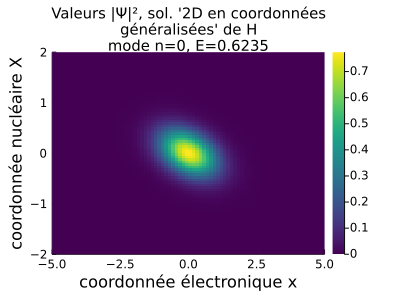

In [16]:
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ, N*N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 
densité = N^2/(ymax-ymin)/(xmax-xmin);
ϕH = lϕ[mode_numérique+1];
ϕH_p = densité*Matrix(transpose(reshape(ϕH.^2,N,N)));
ϕH_p[abs.(ϕH_p) .< 1e-15] .= 0.;
heatmap(xs, ys, ϕH_p,
    xlims = (xmin,xmax),
    ylims = (ymin,ymax),
    xlabel="coordonnée électronique x",
    ylabel="coordonnée nucléaire X",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

### 3) Calcul de l'état fondamental du hamiltonien perturbé $Ĥ⁰+ \lambda Ŵ (\neq Ĥ)$

  0.059779 seconds (5.67 k allocations: 44.909 MiB)
info.converged = 3


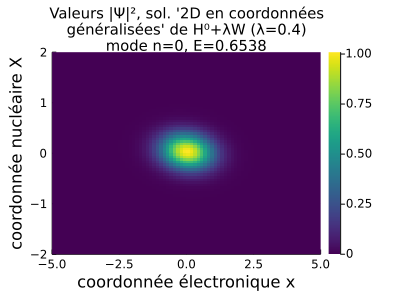

In [17]:
λ = .4;
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 
densité = N^2/(ymax-ymin)/(xmax-xmin);
ϕHλW = lϕ[mode_numérique+1];
ϕHλW_p = densité*Matrix(transpose(reshape(ϕHλW.^2,N,N)));
ϕHλW_p[abs.(ϕHλW_p) .< 1e-15] .= 0.;
heatmap(xs, ys, ϕHλW_p,
    xlims = (xmin,xmax),
    ylims = (ymin,ymax),
    xlabel="coordonnée électronique x",
    ylabel="coordonnée nucléaire X",
    color=:viridis,
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H⁰+λW (λ=$λ)\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    right_margin = 8Plots.mm,
    up_margin = 3Plots.mm)

### 4) Calcul Axe $(Ox)$ de quelques éléments propres (états + énergies) du hamiltonien électronique  $H_x$
On utilise une méthode itérative (Krylov), on ne calcule que les les plus petites énergies

  0.001181 seconds (1.07 k allocations: 335.953 KiB)
infos.converged = 5


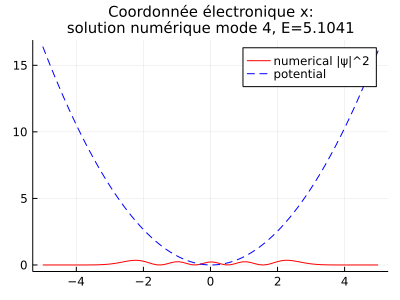

In [18]:
nb_modes_x = 5;
@time lE⁰x, lϕ⁰x, infos = KrylovKit.eigsolve(Ĥ⁰x, N, nb_modes_x, :SR, krylovdim=30);
@show infos.converged
nx = 4; densité_x = N/(xmax-xmin);
plot(xs,
    [densité_x*abs.(lϕ⁰x[nx+1]).^2, V₀x],
    grid=true,
    w=[1 1],
    color = ["red" "blue"],
    linestyle=[:solid :dash],
    label=["numerical |ψ|^2" "potential"],
    title = "Coordonnée électronique x:\nsolution numérique mode $nx, E=$(round(lE⁰x[nx+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 5) Calcul Axe $(Oy)$ de quelques éléments propres (états + énergies) du hamiltonien nucléaire $H_X$

In [19]:
using Polynomials, SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [SpecialPolynomials.basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1Dω = (n,x,m,ω,ħ) -> (m*ω/ħ)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](sqrt(m*ω/ħ)*x)*exp(-m*ω/2/ħ*x^2);
ϕ1Dk = (n,x,m,k,ħ) -> (k*m)^(.125)/ħ^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1]((k*m)^(.25)/sqrt(ħ)*x)*exp(-sqrt(k*m)/2/ħ*x^2);

  0.001293 seconds (1.64 k allocations: 431.797 KiB)
infos.converged = 5


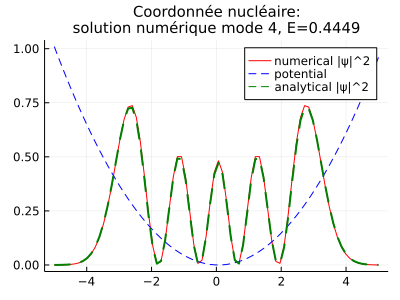

In [20]:
nb_modes_y = 5;
@time lE⁰y, lϕ⁰y, infos = KrylovKit.eigsolve(Ĥ⁰y, N, nb_modes_y, :SR, krylovdim=20);
@show infos.converged
ny = 4; densité_y = N/(ymax-ymin);
sol_analytique_y = [ϕ1Dk(ny,y-y₀,M,∂²yyE₀_at_y₀,ħ) for y in ys];
plot(xs,
    [densité_y*abs.(lϕ⁰y[ny+1]).^2, V₀y, sol_analytique_y.^2],
    grid=true, w=[1 1 2],
    color = ["red" "blue" "green"],
    linestyle=[:solid :dash :dash],
    label=["numerical |ψ|^2" "potential" "analytical |ψ|^2"],
    title = "Coordonnée nucléaire:\nsolution numérique mode $ny, E=$(round(lE⁰y[ny+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 6) Calcul de la solution-produit séparable du hamiltonien non perturbé $H_{HBO}$

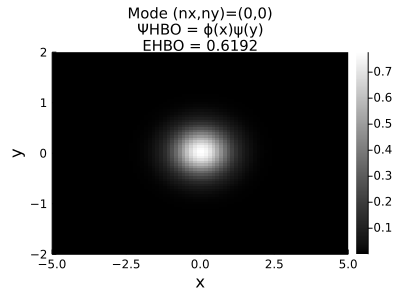

In [21]:
nxc = 0; nyc = 0;
ΨHBO_v = lϕ⁰x[nxc+1] * lϕ⁰y[nyc+1]'; # normé car les deux le sont
ΨHBO = reshape(ΨHBO_v,N*N)
EHBO = lE⁰x[nxc+1] + lE⁰y[nyc+1];
densité = N^2/(ymax-ymin)/(xmax-xmin);
heatmap(xs, ys, densité*ΨHBO_v'.^2,
    color=:greys,
    aspect_ratio=:auto,
    xlim=[xmin,xmax], ylim=[ymin, ymax],
    xlabel='x', ylabel='y',
    size=(400,300),
    titlefontsize=10,
    title = "Mode (nx,ny)=($nxc,$nyc)\nΨHBO = ϕ(x)ψ(y)\nEHBO = $(round(EHBO,digits=4))")

In [22]:
norm(Ĥ⁰*ΨHBO-EHBO*ΨHBO) # on véfifie que c'est bien un vecteur propre

1.3079643383410054e-13

In [15]:
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
@show typeof(HmEHBO);
@show ishermitian(HmEHBO);
@show isposdef(HmEHBO)
@time F = factorize(HmEHBO);
vals, ~, infos = KrylovKit.eigsolve(HmEHBO, N*N, 1, :SR, krylovdim=20); # vérification si la plus petite valeur propre est bien nulle
if infos.converged >= 1
    @show vals[1];
end

typeof(HmEHBO) = SparseMatrixCSC{Float64, Int64}
ishermitian(HmEHBO) = true
isposdef(HmEHBO) = false
  0.613691 seconds (1.91 M allocations: 103.752 MiB, 7.82% gc time, 98.99% compilation time)
vals[1] = 3.7120714212391693e-14


3.7120714212391693e-14

#### Code exemple du rapport

In [37]:
using CUDA
Π = convert(Matrix{Float32}, ΨHBO*ΨHBO');
Π_gpu = cu(Π); # 6400×6400 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
HmEHBO = convert(SparseMatrixCSC{Float32}, Ĥ⁰-Diagonal(EHBO*ones(N*N))); 
HmEHBO_gpu = cu(HmEHBO); # 6400×6400 CUDA.CUSPARSE.CuSparseMatrixCSC{Float32, Int32} with 31680 stored entries:
CUDA.@time HmEHBO_gpu = HmEHBO_gpu*Π_gpu;
CUDA.@time HmEHBO_gpu = Π_gpu*HmEHBO_gpu;

  0.147967 seconds (103 CPU allocations: 4.672 KiB) (1 GPU allocation: 156.250 MiB, 0.01% memmgmt time)
  0.505628 seconds (88 CPU allocations: 4.156 KiB) (1 GPU allocation: 156.250 MiB, 6.25% memmgmt time)


In [16]:
# construction des vecteurs sur GPU ensuite pour les calculs
using CUDA;
CUDA.device_reset!()
CUDA.reclaim()

# Π projecteur sur l'orthogonal de ΨHBO
Π = Matrix(I,N*N,N*N) - ΨHBO*ΨHBO';
Π_32       = convert(Matrix{Float32}, Π); # changer en double précision 64 bits des GPU équipés de cœors adaptés (cluster)
Π_gpu      = cu(Π_32);

# H - E0
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
HmEHBO_32  = convert(SparseMatrixCSC{Float32}, HmEHBO); # idem
HmEHBO_gpu = cu(HmEHBO_32);

# Ŵ Perturbation
# ... W existe déjà
W_32 = convert(Matrix{Float32}, Ŵ);
W_gpu = cu(W_32);

# membre de droite
bcg = -Π*Ŵ*ΨHBO # toujours faire les produits avant de convertir en 32bits au possible
bcg_32 = convert(Array{Float32}, bcg);
bcg_gpu = cu(bcg_32);

# application linéaire sur laquelle résoudre
Acg = Π*HmEHBO*Π;
Acg_32 = convert(Matrix{Float32}, Acg);
Acg_gpu = cu(Acg_32);


# types 
@show typeof(Π_gpu);
@show typeof(HmEHBO_gpu);
@show typeof(W_gpu);
@show typeof(bcg_gpu);


typeof(Π_gpu) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
typeof(HmEHBO_gpu) = CUDA.CUSPARSE.CuSparseMatrixCSC{Float32, Int32}
typeof(W_gpu) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
typeof(bcg_gpu) = CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}


┌ Warning: Unable to use CUDA from artifacts: The artifact at C:\Users\matth\.julia\artifacts\fd3b38cf5ade69a121c1ed6bc7a0a47f930ac0a1 is empty.
│ This is probably caused by a failed download. Remove the directory and try again.
└ @ CUDA.Deps C:\Users\matth\.julia\packages\CUDA\GGwVa\deps\bindeps.jl:84


In [17]:
# gradients conjugués avec et sans gpu
using IterativeSolvers;

# ordre 1
CUDA.@time Ψ1_gpu = cg(Acg_gpu, bcg_gpu);
@time      Ψ1_32  = cg(Acg_32, bcg_32);
# @assert Ψ1_32 ≈ Vector(Ψ1_gpu);
E1 = (ΨHBO+λ*Ψ1_32)'*(Ĥ⁰+λ*Ŵ)*(ΨHBO+λ*Ψ1_32);

# ordre 2 (gpu uniquement)
# màj membre de droite
bcg_gpu = -Acg_gpu*Ψ1_gpu + E1*Ψ1_gpu # toujours faire les produits avant de convertir en 32bits au possible
CUDA.@time Ψ2_gpu = cg(Acg_gpu, bcg_gpu);

 33.074240 seconds (70.70 M CPU allocations: 3.686 GiB, 2.99% gc time) (4 GPU allocations: 56.250 KiB, 0.00% memmgmt time)
  0.406095 seconds (1.24 M allocations: 65.637 MiB, 81.24% compilation time)
 10.692565 seconds (37.63 M CPU allocations: 1.949 GiB, 3.94% gc time) (4 GPU allocations: 112.500 KiB, 0.00% memmgmt time)


In [18]:
heatmap(xs,ys, densité*transpose(reshape((ΨHBO+λ*Ψ1_32+λ^2*Array(Ψ2_gpu)).^2,N,N)),
    xlims = (xmin,xmax),
    ylims = (ymin,ymax),
    xlabel="coordonnée électronique x",
    ylabel="coordonnée nucléaire X",
    color=:viridis,
    title = "Valeurs |ΨHBO+λΨ1|², sol. num.\n grad. conj. de H⁰+λW (λ=$λ)\nmode n=$mode_numérique, E=$(round(EHBO+ \lE1,digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    right_margin = 8Plots.mm,
    up_margin = 4Plots.mm)

ErrorException: syntax: "\" is not a unary operator

In [19]:
norm(ΨHBO+λ*Ψ1_32+λ^2*Array(Ψ2_gpu))

1.2550835154599118

### 7) Perturbation "Sum over states" au premier ordre avec $W$

In [20]:
function méthode_perturbations_o1(Ŵ, lϕ⁰x, lϕ⁰y, lE⁰x, lE⁰y, N, nx, ny, λ)
    Ix = length(lE⁰x);
    Iy = length(lE⁰y);
    couples_énergies = sort(reshape(collect(product(
                                                    collect(Iterators.zip(lE⁰x, Base.OneTo(Ix))),
                                                    collect(Iterators.zip(lE⁰y, Base.OneTo(Iy)))
                                                    )
                                            ),
                                    Ix*Iy), by=X->X[1][1]+X[2][1]);
    lE⁰   = (x->x[1][1] + x[2][1]).(couples_énergies);
    indices_modes    = (x->(x[1][2], x[2][2])).(couples_énergies);
    

    ϕHBO = reshape(lϕ⁰x[nx+1] * lϕ⁰y[ny+1]',N*N); # état propre HBO
    EHBO = lE⁰x[nx+1] + lE⁰y[ny+1]; # énergie propre HBO

    
    # correction au vecteur propre au premier ordre
    ψ₁ = zeros(N*N)
    for k=1:Ix*Iy
        ϕk = reshape(lϕ⁰x[indices_modes[k][1]] * lϕ⁰y[indices_modes[k][2]]',N*N);
        @views res = indices_modes[k] == (nx+1,ny+1) ? 0 : -1/(lE⁰[k] - EHBO) * (ϕk'*Ŵ*ϕHBO);
        # formule B-11 du Cohen-Tanoudji, chapitre 11, page 1127 ou voir également poly Cances exo 8.2
        ψ₁ += res * ϕk;
        # println(indices_modes[k], " norm(res)=$(norm(res))") # débugg
    end
    ϕ = ϕHBO +λ*ψ₁;
    ϕ = ϕ/norm(ϕ);

    # correction à l'énergieà l'ordre 1 et 2
    E1 = ϕHBO'*Ŵ*ϕHBO;
    E2 = ϕHBO'*Ŵ*ψ₁;
    Ec₁ = EHBO + λ*E1;
    Ec₂ = EHBO + λ*E1 + λ^2*E2;
    return Ec₁, Ec₂, ϕ, couples_énergies, lE⁰, indices_modes
end


# Ec₁, Ec₂, ϕc, cpl_en, en_m, ind_m = méthode_perturbations_o1(Ŵ, lϕ⁰x, lϕ⁰y, lE⁰x, lE⁰y, N, nxc, nyc, λ);

# heatmap(xs, ys, transpose(densité*reshape(ϕc,N,N).^2),
    color=:greys,
    aspect_ratio=:equal,
    xlim=[xmin,xmax], ylim=[ymin, ymax],
    size=(400,300),
    titlefontsize=10,
    xlabel='x', ylabel='y', title = "Mode ($nxc,$nyc) approché\nau premier ordre par Born-Oppenheimer\nÉnergie à l'ordre 2 E=$(round(Ec₂,digits=4))")

ErrorException: syntax: extra token ")" after end of expression

On retrouve notre état fondamental calculé numériquement en 2D ainsi qu'une très bonne approximation de l'énergie. À  comparer avec la figure 'solution numérique 2D' plus haut. L'énergie en particulier est une excellente approximation à l'ordre 2 que l'on obtient avec l'aide de l'état à l'ordre 1 (moins d'un \% d'erreur)

Pour conclure, on a comparé entre eux
* l'état fondamental d'énergie la plus basse indicé 0 calculé avec Krylov "en 2D" (avec le hamiltonien perturbé  $Ĥ⁰+ \lambda Ŵ$ associée au système complet noyau + électron)
* le produit des états fondamentaux numériques indicés 0 de chaque hamiltonien non perturbé $Ĥ⁰_x$ et $Ĥ⁰_y$ (pour $H_y$ qui est exactement un oscillateur harmonique quantique on aurait pu aussi calculer l'état fondamental 1D avec la formule analytique connue)

In [16]:
# pour la poursuite du code et l'étude de la convergence numérique des résultats on peut calculer la norme 2 de la différence entre les deux vecteurs propres correspondants:
norm(ϕg - ϕc)/150^2*(xmax-xmin)*(ymax-ymin);

# rayon de convergence en λ
# norme H¹
# rescaling: l'état devrait se stabiliser
# trouver le régime où les 2 marchent bien
# faire tendre la masse vers +∞

# en 1D: prendre un potentiel de coulomb régularisé en 1/sqrt(x² + α²)
# estimer l'erreur des vap en fonction des résidus en fct de HΨ et Eψ
# formule de Kato Temple
# voir le gap de KT avec le gap numérique de Born-Oppenheimer
# idée: implémenter des erreurs a posteriori
# en dim 6: méthodes de tenseurs
# voir également avec virginie porte en face d'Eric, chercheuse permanente du CERMICS, spécialiste des tenseurs

0.0019403500699984274

### 8) Perturbation "Sum over States" à tout ordre avec $W$

In [42]:
function get_eigenmodes(lE⁰x, lE⁰y, lϕ⁰x, lϕ⁰y, Ix, Iy)
    @assert Ix == length(lE⁰x) == length(lϕ⁰x)
    @assert Iy == length(lE⁰y) == length(lϕ⁰y)
    couples_énergies = sort(reshape(collect(product(
                                                    collect(Iterators.zip(lE⁰x, Base.OneTo(Ix))),
                                                    collect(Iterators.zip(lE⁰y, Base.OneTo(Iy)))
                                                    )
                                            ),
                                    Ix*Iy), by=X->X[1][1]+X[2][1]);
    lE⁰ = (x->x[1][1] + x[2][1]).(couples_énergies);
    indices_modes    = (x->(x[1][2], x[2][2])).(couples_énergies);

    lϕ = reduce( # construction de la base des vecteurs propres HBO aplatis une bonne fois pour toutes
                hcat,
                collect(
                        [reshape(lϕ⁰x[indices_modes[k][1]] * lϕ⁰y[indices_modes[k][2]]',N*N) for k in 1:Ix*Iy]
                        )
                );
    return couples_énergies, indices_modes, lϕ, lE⁰
end



function sum_over_states_oq(Ŵ, lϕ⁰x, lϕ⁰y, lE⁰x, lE⁰y, N, nx, ny, λ, qmax, ψr) # q est l'ordre maximal
    # (nx,ny) correspond à ind_approx dans la version 2D démonstrateur
    @assert N == size(lϕ⁰x[1])[1] # vérification de la dimension de l'état; doit valoir N
    Ix = length(lE⁰x); # nombre d'états pris en compte pour la dimension suivant (Ox)
    Iy = length(lE⁰y); # nombre d'états pris en compte pour la dimension suivant (Oy)
    @assert qmax ≤ Ix*Iy;       # on ne peut pas calculer un ordre supérieur ou égal au nombre de modes dont on dispose
    lΨ = zeros(N^2, qmax);  # liste   des termes-vecteurs ψq pour l'ordre q ∈ {1,2,...,qmax} pour le vecteur
    lE = zeros(qmax);       # liste   des termes-énergie  Eq pour l'ordre q ∈ {1,2,...,qmax} pour l'énergie
    lNd = zeros(qmax);        # liste des normes 2 des différences entre solution de référence et chaque approximation à l'ordre q
    mA   = zeros(Ix*Iy,qmax);   # matrice des αiq, décomposition des (ψq = Σ_i∈1:dim αiq.ϕi) dans la base des ϕᵢ pour chaque ordre q ∈ {1,2,...,qmax} 

    couples_énergies, indices_modes, lϕ, lE⁰ = get_eigenmodes(lE⁰x, lE⁰y, lϕ⁰x, lϕ⁰y, Ix, Iy);
    
    ϕHBO = reshape(lϕ⁰x[nx+1] * lϕ⁰y[ny+1]',N*N); # état propre HBO; correspond à ϕ_j dans les équations
    EHBO = lE⁰x[nx+1] + lE⁰y[ny+1]; # énergie propre HBO
    ψc = zeros(N*N); # ce sera le vecteur mis à jour avec la théorie des perturbations
    Ec = 0;
    ψc += ϕHBO;
    Ec += EHBO;

    # terme énergie au premier ordre
    lE[1] = ϕHBO'*Ŵ*ϕHBO;
    Ec += λ*lE[1];

    # terme vecteur au premier ordre
    for k=1:Ix*Iy # sum over states
        α1k  =  indices_modes[k] == (nx+1,ny+1) ? 0 : -1/(lE⁰[k] - EHBO) * lϕ[:,k]'*Ŵ*ϕHBO; # formule B-11 du Cohen-Tanoudji, chapitre 11, page 1127 ou voir également poly Cances exo 8.1
        ### bA[k,1] =  α1k; # on sauvegarde le coef de l'ordre 1 sur le vecteur ϕk
        lΨ[:,1] += α1k * lϕ[:,k]; # on update ψ1 dans la liste des vecteurs à tout ordre
    end
    ψc += λ*lΨ[:,1];
    lNd[1] = norm(ψc - ψr)/densité;
    # println("succès ordre 1")



    ŴmE1 = Ŵ .- Diagonal(lE[1]*ones(N*N));

    
    for q=2:qmax
    # terme énergie à l'ordre q ≥ 2 D'ABORD
        lE[q] = ϕHBO'*ŴmE1*lΨ[:,q-1] - sum([lE[r] * ϕHBO' * lΨ[:,q-r] for r in 2:q-1])
        Ec += (λ^q)*lE[q];
        # terme vecteur à l'ordre q ≥ 2
        for k=1:Ix*Iy
            αqj = -1/2*sum([lΨ[:,r]'*lΨ[:,q-r] for r in 1:q-1]);
            αqknj = -1/(lE⁰[k] - EHBO)*( - lϕ[:,k]'*ŴmE1*lΨ[:,q-1] + sum([lE[r] * lϕ[:,r]'*lΨ[:,q-r] for r in 2:q-1]) + lE[q]*lϕ[:,q]' * ϕHBO);
            αqk = indices_modes[k] == (nx+1,ny+1) ? αqj : αqknj;
            # formule 2.43 ou 2.48 de mon rapport suivant le test
            ### bA[k,q] = αqk; # on sauvegarde la composante de l'ordre q sur le vecteur ϕk
            lΨ[:,q] += αqk * lϕ[:,k]; # on update ψq dans la liste des vecteurs à tout ordre
        end
        ψc += λ^q*lΨ[:,q];
        lNd[q] = norm(ψc - ψr)/densité;
        # println("succès ordre $q")
    end

    @views mA[:,:] = lϕ'*lΨ; # enfin, puisque les ϕᵢ sont orthogonaux entre eux (théoriquement),
                             # on calcule les coefficients αiq, i.e. projeté de chaque Ψ sur les ϕᵢ
    return ϕHBO, EHBO, lΨ, mA, lNd, lE, couples_énergies, lE⁰, lϕ, indices_modes, ψc, Ec
end

sum_over_states_oq (generic function with 1 method)

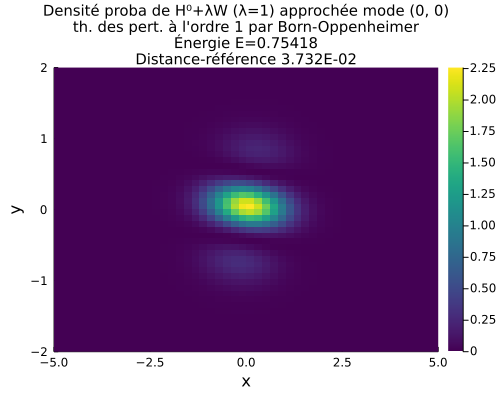

In [43]:
qmax = 1; λ = 1;
ϕHBO, EHBO, lΨ, mA, lNd, lE, couples_énergies, lE⁰, lϕ, indices_modes, ψc, Ec = sum_over_states_oq(Ŵ, lϕ⁰x, lϕ⁰y, lE⁰x, lE⁰y, N, nxc, nyc, λ, qmax, ϕHλW);

using Printf
dist_ref = round(norm(ϕHλW-ψc)/densité,digits=6);

densité = N^2/(ymax-ymin)/(xmax-xmin);
ψc_p = densité*Matrix(transpose(reshape(ψc.^2,N,N)));
ψc_p[abs.(ψc_p) .< 1e-15] .= 0.;
heatmap(xs, ys, ψc_p,
    color=:viridis,
    aspect_ratio=:auto,
    xlim=[xmin,xmax], ylim=[ymin, ymax],
    xlabel='x', ylabel='y',
    size=(500,400),
    titlefontsize=10,
    title = "Densité proba de H⁰+λW (λ=$λ) approchée mode ($nxc, $nyc)\nth. des pert. à l'ordre $qmax par Born-Oppenheimer\nÉnergie E=$(round(Ec,digits=5))\nDistance-référence $(@sprintf("%.3E",dist_ref))")

### [Work in progress] Projection à tout ordre

In [281]:
function projection_oq(Ŵ, lϕ⁰x, lϕ⁰y, lE⁰x, lE⁰y, N, nx, ny, λ, qmax, ψr) # q est l'ordre maximal
    # (nx,ny) correspond à ind_approx dans la version 2D démonstrateur: on met 0,0 pour le fondamental
    @assert N == size(lϕ⁰x[1])[1] # vérification de la dimension de l'état; doit valoir N
    Ix = length(lE⁰x); # nombre d'états pris en compte pour la dimension suivant (Ox)
    Iy = length(lE⁰y); # nombre d'états pris en compte pour la dimension suivant (Oy)
    @assert qmax ≤ Ix*Iy;       # on ne peut pas calculer un ordre supérieur ou égal au nombre de modes dont on dispose
    lΨ = zeros(N^2, qmax);  # liste   des termes-vecteurs ψq pour l'ordre q ∈ {1,2,...,qmax} pour le vecteur
    lE = zeros(qmax);       # liste   des termes-énergie  Eq pour l'ordre q ∈ {1,2,...,qmax} pour l'énergie
    lNd = zeros(qmax);        # liste des normes 2 des différences entre solution de référence et chaque approximation à l'ordre q
    mA   = zeros(Ix*Iy,qmax);   # matrice des αiq, décomposition des (ψq = Σ_i∈1:dim αiq.ϕi) dans la base des ϕᵢ pour chaque ordre q ∈ {1,2,...,qmax} 

    couples_énergies = sort(reshape(collect(product(
                                                    collect(Iterators.zip(lE⁰x, Base.OneTo(Ix))),
                                                    collect(Iterators.zip(lE⁰y, Base.OneTo(Iy)))
                                                    )
                                            ),
                                    Ix*Iy), by=X->X[1][1]+X[2][1]);
    lE⁰ = (x->x[1][1] + x[2][1]).(couples_énergies);
    indices_modes    = (x->(x[1][2], x[2][2])).(couples_énergies);

    lϕ = reduce( # construction de la base des vecteurs propres HBO aplatis en Matrix{Float64}
                hcat,
                collect(
                        [reshape(lϕ⁰x[indices_modes[k][1]] * lϕ⁰y[indices_modes[k][2]]',N*N) for k in 1:Ix*Iy]
                        )
                );
    
    ϕHBO = reshape(lϕ⁰x[nx+1] * lϕ⁰y[ny+1]',N*N); # état propre HBO; correspond à ϕ_j dans les équations
    EHBO = lE⁰x[nx+1] + lE⁰y[ny+1]; # énergie propre HBO
    ψc = zeros(N*N); # ce sera le vecteur mis à jour avec la théorie des perturbations
    Ec = 0;
    ψc += ϕHBO;
    Ec += EHBO;

    # calcul du projecteur 
    Π = ϕHBO*ϕHBO';
    
end

projection_oq (generic function with 1 method)